# Mutant Analysis

TODO describe some previous results (mostly data processing)

## 0) Imports

In [1]:
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt

from src.scripts.mutants_analysis import compute_variation_ic50, plot_ic50_graph, compute_multiple_alignment, plot_ic50_both_graphs, bar_plot_df
from src.scripts.website_plots import save_dfs_ligands

2024-12-18 16:30:44.301877: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1) Impact of Mutations in Reference-Mutant Protein Groups on Ligand Binding Affinities

To illustrate the analyses performed to answer this research question, we focus on a single reference-mutant group that includes all types of mutations: insertions, deletions, and substitutions.
The reference chosen is Epidermal growth factor receptor in humans.

**Note: The processing of the binding DB dataset is detailed in the P2 results and is not included here to maintain the notebook's focus and conciseness.**

In [2]:
# Read mutants.csv containing the reference-mutant protein groups
mutants_df = pd.read_csv('data/mutants.csv')
# Modify the columns for how they are formatted after to_csv function
mutants_df['Target Names'] = mutants_df['Target Names'].apply(lambda x: ast.literal_eval(x))
mutants_df['BindingDB Target Chain Sequence'] = mutants_df['BindingDB Target Chain Sequence'].apply(lambda x: ast.literal_eval(x))

# Read merged_df.csv containing the IC50 values for each interaction
merged_df = pd.read_csv('data/merged_df.csv')

# Indentify the reference-mutant protein group we are interested in showing
row = mutants_df.iloc[3975]

# Compute variations in IC50
differences_explode, grouped_df, differences = compute_variation_ic50(row, merged_df)

Device set to use cpu


The first step in our analysis involved extracting information about the differences between each mutant sequence and the reference sequence. This was achieved through pairwise alignment of the reference proteins with their corresponding mutants. While some of this information is encoded in the mutant names, their unformatted notation and occasional errors (e.g., incorrect numbering like 7350 instead of 735) made direct use impractical and time-consuming.

The pairwise alignment method used in this analysis is the [Needleman-Wunsch algorithm](https://en.wikipedia.org/wiki/Needleman%E2%80%93Wunsch_algorithm), which is a global alignment technique. Global alignment ensures that the entire length of both sequences is aligned from start to finish. By applying this global alignment approach, we were able to identify all the differences (insertions, deletions, and substitutions) between the mutant sequences and the reference sequence.
To perform the pairwise sequence alignment, the alignment scoring system was modified to suit our specific goals. In particular, the penalty for gap extensions was reduced to reflect the likelihood of large gaps occurring, rather than smaller gaps accompanied by substitutions or matches within them. This adjustment ensured that the alignment could effectively capture large deletions or insertions without over-penalizing small gaps, thus providing more accurate results.

After the pairwise alignment between a mutant and the reference protein was completed, it was necessary to identify the deletions, insertions, and substitutions. The goal was to precisely pinpoint which amino acids were altered, as this information would be critical for further analysis. To achieve this, multiple tests and checks were performed to ensure accurate identification of the variations and to resolve any ambiguities in the alignment results.

In this section, we provide an example of the differences identified between the reference protein and its mutants. For instance, the mutant name EGFR [1-18,20-1210,C797S] indicates a deletion at position 19 and a mutation at position 797. By aligning sequences, we observe a deletion at position 18 (calculated as 19 - 1, assuming zero-based indexing) and a substitution at position 796.

In [3]:
# Show differences between reference and mutant in one reference-mutant protein group
differences[['Mutant Name', 'Insertion Positions', 'Deletion Positions', 'Substitution Positions']]

,Mutant Name,Insertion Positions,Deletion Positions,Substitution Positions
0,"Epidermal growth factor receptor [1-18,20-1210...",[],[18],[796]
1,"Epidermal growth factor receptor [1-18,20-1210...",[],[18],"[789, 796]"
2,"Epidermal growth factor receptor [1-18,20-1210...",[],[18],[789]
3,"Epidermal growth factor receptor [1-18,20-1210]",[],[18],[]
4,"Epidermal growth factor receptor [1-769,'ASV',...","[769, 770, 771]",[],[]
5,"Epidermal growth factor receptor [1-773,'NPH',...","[773, 774, 775]",[],[]
6,"Epidermal growth factor receptor [668-1210,T79...",[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[789, 857]"
7,"Epidermal growth factor receptor [L858R,C797S]",[],[],"[796, 857]"
8,"Epidermal growth factor receptor [L858R,T790M,...",[],[],"[789, 796, 857]"
9,Epidermal growth factor receptor [L858R],[],[],[857]


The same information can be presented in different formats, depending on how we choose to display it. For instance, here we organize the data by mutation type. The first line from the previous dataframe is now split into two separate lines, both sharing the same Mutant Name. The first line specifies the substitution, detailing the exact change from one amino acid to another, while the second line represents a gap.

In [4]:
grouped_df[['Mutant Name', 'Type', 'Mutation', 'Positions']]

,Mutant Name,Type,Mutation,Positions
0,"Epidermal growth factor receptor [1-18,20-1210...",substitution,Cysteine -> Serine,[796]
1,"Epidermal growth factor receptor [1-18,20-1210...",gap,Deletion,[18]
2,"Epidermal growth factor receptor [1-18,20-1210...",substitution,Threonine -> Methionine,[789]
3,"Epidermal growth factor receptor [1-18,20-1210...",substitution,Cysteine -> Serine,[796]
4,"Epidermal growth factor receptor [1-18,20-1210...",gap,Deletion,[18]
5,"Epidermal growth factor receptor [1-18,20-1210...",substitution,Threonine -> Methionine,[789]
6,"Epidermal growth factor receptor [1-18,20-1210...",gap,Deletion,[18]
7,"Epidermal growth factor receptor [1-18,20-1210]",gap,Deletion,[18]
8,"Epidermal growth factor receptor [1-769,'ASV',...",insertion,"[Alanine, Serine, Valine]","[769, 770, 771]"
9,"Epidermal growth factor receptor [1-773,'NPH',...",insertion,"[Asparagine, Proline, Histidine]","[773, 774, 775]"


### MSA

The Multiple Sequence Alignment (MSA) process begins by using the reference sequence as the template for alignment. Each mutant sequence is aligned to the reference using the pairwise alignment method discussed earlier. When no insertions are present in the mutants, the MSA is simply the concatenation of the individual pairwise alignments, as this is a specific case where the reference sequence is the template. If insertions are present, they are identified, and the alignment is modified by inserting gaps at the corresponding positions. The mutant sequences are then adjusted by adding gaps at the identified insertion sites. The final alignment places the reference sequence at the top, with the mutant sequences aligned below it.

This MSA allows for a quick comparison not only between the reference sequence and the mutant sequences but also between the mutants themselves, facilitating a better understanding of how the variations in the sequences relate to the changes in IC50 values.



In [5]:
# Compute alignment
align = compute_multiple_alignment(row['WT Target Name'], row['Target Names'], row['BindingDB Target Chain Sequence'])
align

,Protein Name,Alignment
0,Epidermal growth factor receptor,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...
1,"Epidermal growth factor receptor [1-18,20-1210...",MRPSGTAGAALLALLAAL-PASRALEEKKVCQGTSNKLTQLGTFED...
2,"Epidermal growth factor receptor [1-18,20-1210...",MRPSGTAGAALLALLAAL-PASRALEEKKVCQGTSNKLTQLGTFED...
3,"Epidermal growth factor receptor [1-18,20-1210...",MRPSGTAGAALLALLAAL-PASRALEEKKVCQGTSNKLTQLGTFED...
4,"Epidermal growth factor receptor [1-18,20-1210]",MRPSGTAGAALLALLAAL-PASRALEEKKVCQGTSNKLTQLGTFED...
5,"Epidermal growth factor receptor [1-769,'ASV',...",MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...
6,"Epidermal growth factor receptor [1-773,'NPH',...",MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...
7,"Epidermal growth factor receptor [668-1210,T79...",----------------------------------------------...
8,"Epidermal growth factor receptor [L858R,C797S]",MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...
9,"Epidermal growth factor receptor [L858R,T790M,...",MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...


Here we present a visualization of the MSA, with insertions highlighted in green, substitutions in yellow, and deletions in red.

![title](images/msa.png)

### Scatter plots

To visualize the impact of specific mutations on binding affinity, we decided to first use scatter plots for a given interaction pair Wild-Type protein - Ligand. We here describe such result for one interaction pair, but the plots for all other interaction pairs can be found on our website. The information about each interaction pair is given in the following dataframe. We thus focus our study here on interaction 3: between the ligand N-(3-chloro-4-fluorophenyl)-7-methoxy-6-(3-morpholin-4-ylpropoxy)quinazolin-4-amine and the WT protein EGFR_HUMAN.

In [6]:
interaction_pairs = pd.read_csv('src/data/interaction_pairs.csv', index_col='Unnamed: 0')
interaction_pairs

,Ligand SMILES,Ligand name,WT protein
0,CN(C)C\C=C\C(=O)N1CCCC[C@H](C1)n1c(NC(=O)c2ccn...,N-[7-chloro-1-[(3R)-1-[(E)-4-(dimethylamino)bu...,EGFR_HUMAN
1,CN(C)C\C=C\C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2...,(E)-N-[4-(3-chloro-4-fluoroanilino)-7-[(3S)-ox...,EGFR_HUMAN
2,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1,N-(3-chloro-4-fluorophenyl)-7-methoxy-6-(3-mor...,EGFR_HUMAN
3,C[C@@H](N)[C@H]1CC[C@@H](CC1)C(=O)Nc1ccncc1,4-[(1R)-1-aminoethyl]-N-pyridin-4-ylcyclohexan...,KAPCA_BOVIN
4,C[C@H]1CNCCCN1S(=O)(=O)c1cccc2cncc(C)c12,"4-methyl-5-[[(2S)-2-methyl-1,4-diazepan-1-yl]s...",KAPCA_BOVIN


The scatter plots is as such:
- x-axis represents the position of the mutation on the sequence
- y-axis represents the log of the ratio of the IC50 for the WT and the IC50 for the mutant: $\log \frac{\text{IC50}_{mutant}}{\text{IC50}_{WT}}$
- crosses represent deletions 
- circles represent point mutations
- triangles represent insertions
- each mutant has a specific color

We decided to plot the log ratio since values had a big range and to be able to visualize everything at the same time this was the best option. First, we took the ratio of the IC50 values for the mutant and the WT. A better binding affiinity being defined by small values of IC50, a ratio greater than 1 means that the IC50 value was bigger for the mutant than for the WT, indicating a non-beneficial mutation. Thus, a ratio smaller than 1 represents a beneficial mutation. Since we take the log of this ratio, a positive value on the y-axis represent a non-beneficial mutation and a negative value repreesents a beneficial mutation. 

Device set to use cpu


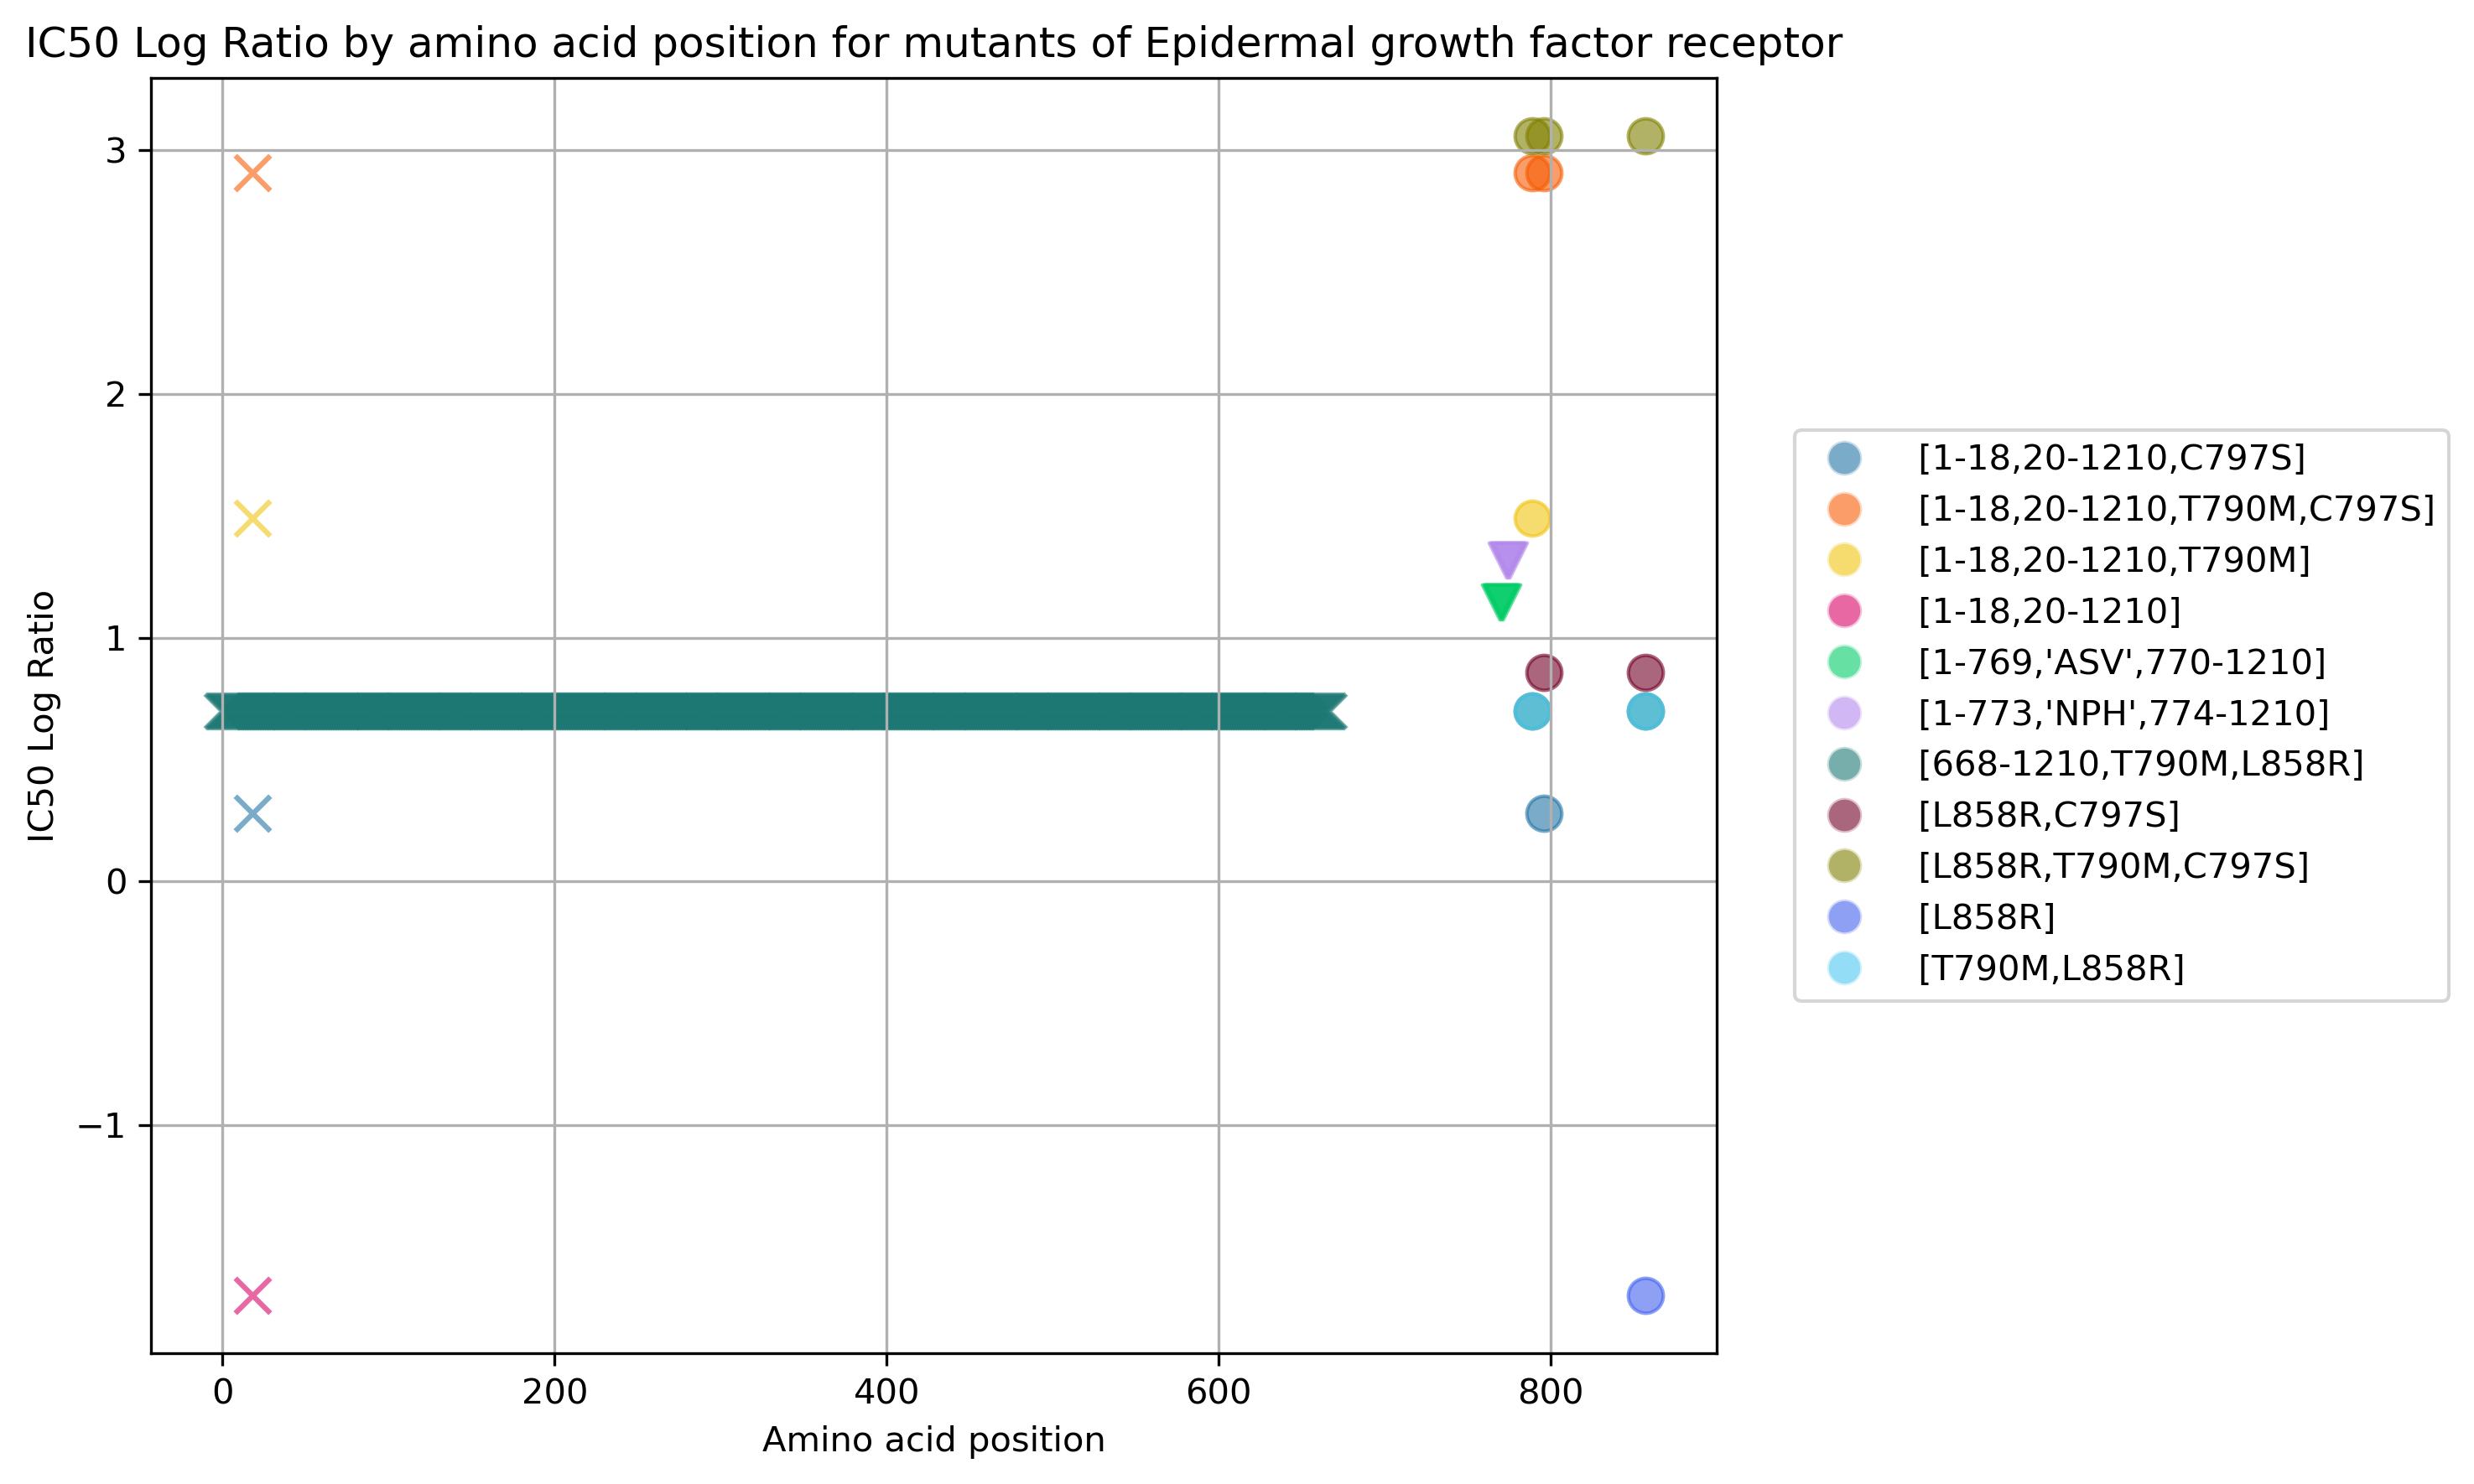

In [7]:
# Plot IC50 log ratio
plot_ic50_graph(row, merged_df, 'IC50 Log Ratio', title='IC50 Log Ratio')

We see that the two first mutants ([1-18,20-1210,C797S], [1-18,20-1210,T790M, C797S]) are very similar in terms of mutations, i.e., the second mutant has one extra point mutation at position 790 (from T to M). Nevertheless, we see a big difference on the y-axis between those two mutants. We can thus understand that the mutation at position 790 reduces a lot the binding affinity (even if most of the mutations on this plot are non-beneficial). The same exact conclusion can be drawn by looking at mutants 3 and 4 ([1-18,20-1210,T790M], [1-18,20-1210]), mutants 8 and 9 ([L858R, C797S], [L858R, T790M, C797S]), and mutants 10 and 11 ([L858R], [T790M, L858R]). 

A next step for this project could be to dig further in this given interaction and visualize the 3D structure of the binding to understand the importance of the mentioned position. This could be used to validate experimentally found results.

Finally, the only two beneficial mutations are the mutants [1-18, 20-1210] (deletion at position 19) and [L858R] (Leucine to Arginine at position 858).

--------------------------------

The ESM2 probabilities are computed by analyzing the specific mutation type (substitution, insertion, or deletion) within the protein sequence. If the mutation is a substitution, the function masks the position of the mutated amino acid in the sequence and calculates the difference in probabilities between the new amino acid and the previous one, using the ESM2 model. This is done by first obtaining the probabilities for all possible amino acids at the substituted position. Then, the probability of the new amino acid (post-substitution) is compared to the probability of the original amino acid (pre-substitution), and the difference between these two probabilities is returned.

For insertions or deletions, since ESM2 was not trained to handle gaps, the function returns a probability difference of 0, indicating that these mutations are not processed in terms of probability variation. In particular, ESM2 is a masked language model, which means it was trained by randomly masking one position in a protein sequence and then predicting the most probable amino acid for that position based on the surrounding context (the amino acid sequence). During training, ESM2 learns to predict the probability distribution of possible amino acids for any masked position, but it does not directly account for the insertion or deletion of amino acids, which correspond to gaps in a sequence. Because of this, the model was not trained to handle indels (insertions or deletions). When a gap is introduced into a sequence, the probability of the gap token itself is always lower than the probability of any amino acid token, as the model is primarily focused on predicting actual amino acids rather than representing missing positions. Therefore, including gaps in the analysis would not provide meaningful results, as the probability of gaps would not be comparable to the probabilities of amino acids. For this reason, gaps are not considered in the probability calculations for this analysis.

In summary, for substitutions, the function provides a measure of how the probability of the amino acid at a given position changes due to the mutation, while for insertions and deletions, it returns 0 due to the limitations of the model with respect to gaps.

Once we obtained those probabilities, we were able to generate the exact same plot as before but slightly changing it by:
- only keeping substitutions as ESM2 was not trained for deletions and insertions (as previously discussed)
- coloring the points based on the difference in probability

If the probability difference is positive this means that the mutated amino acid is more probable than the WT amino acid according to ESM2. 

Device set to use cpu


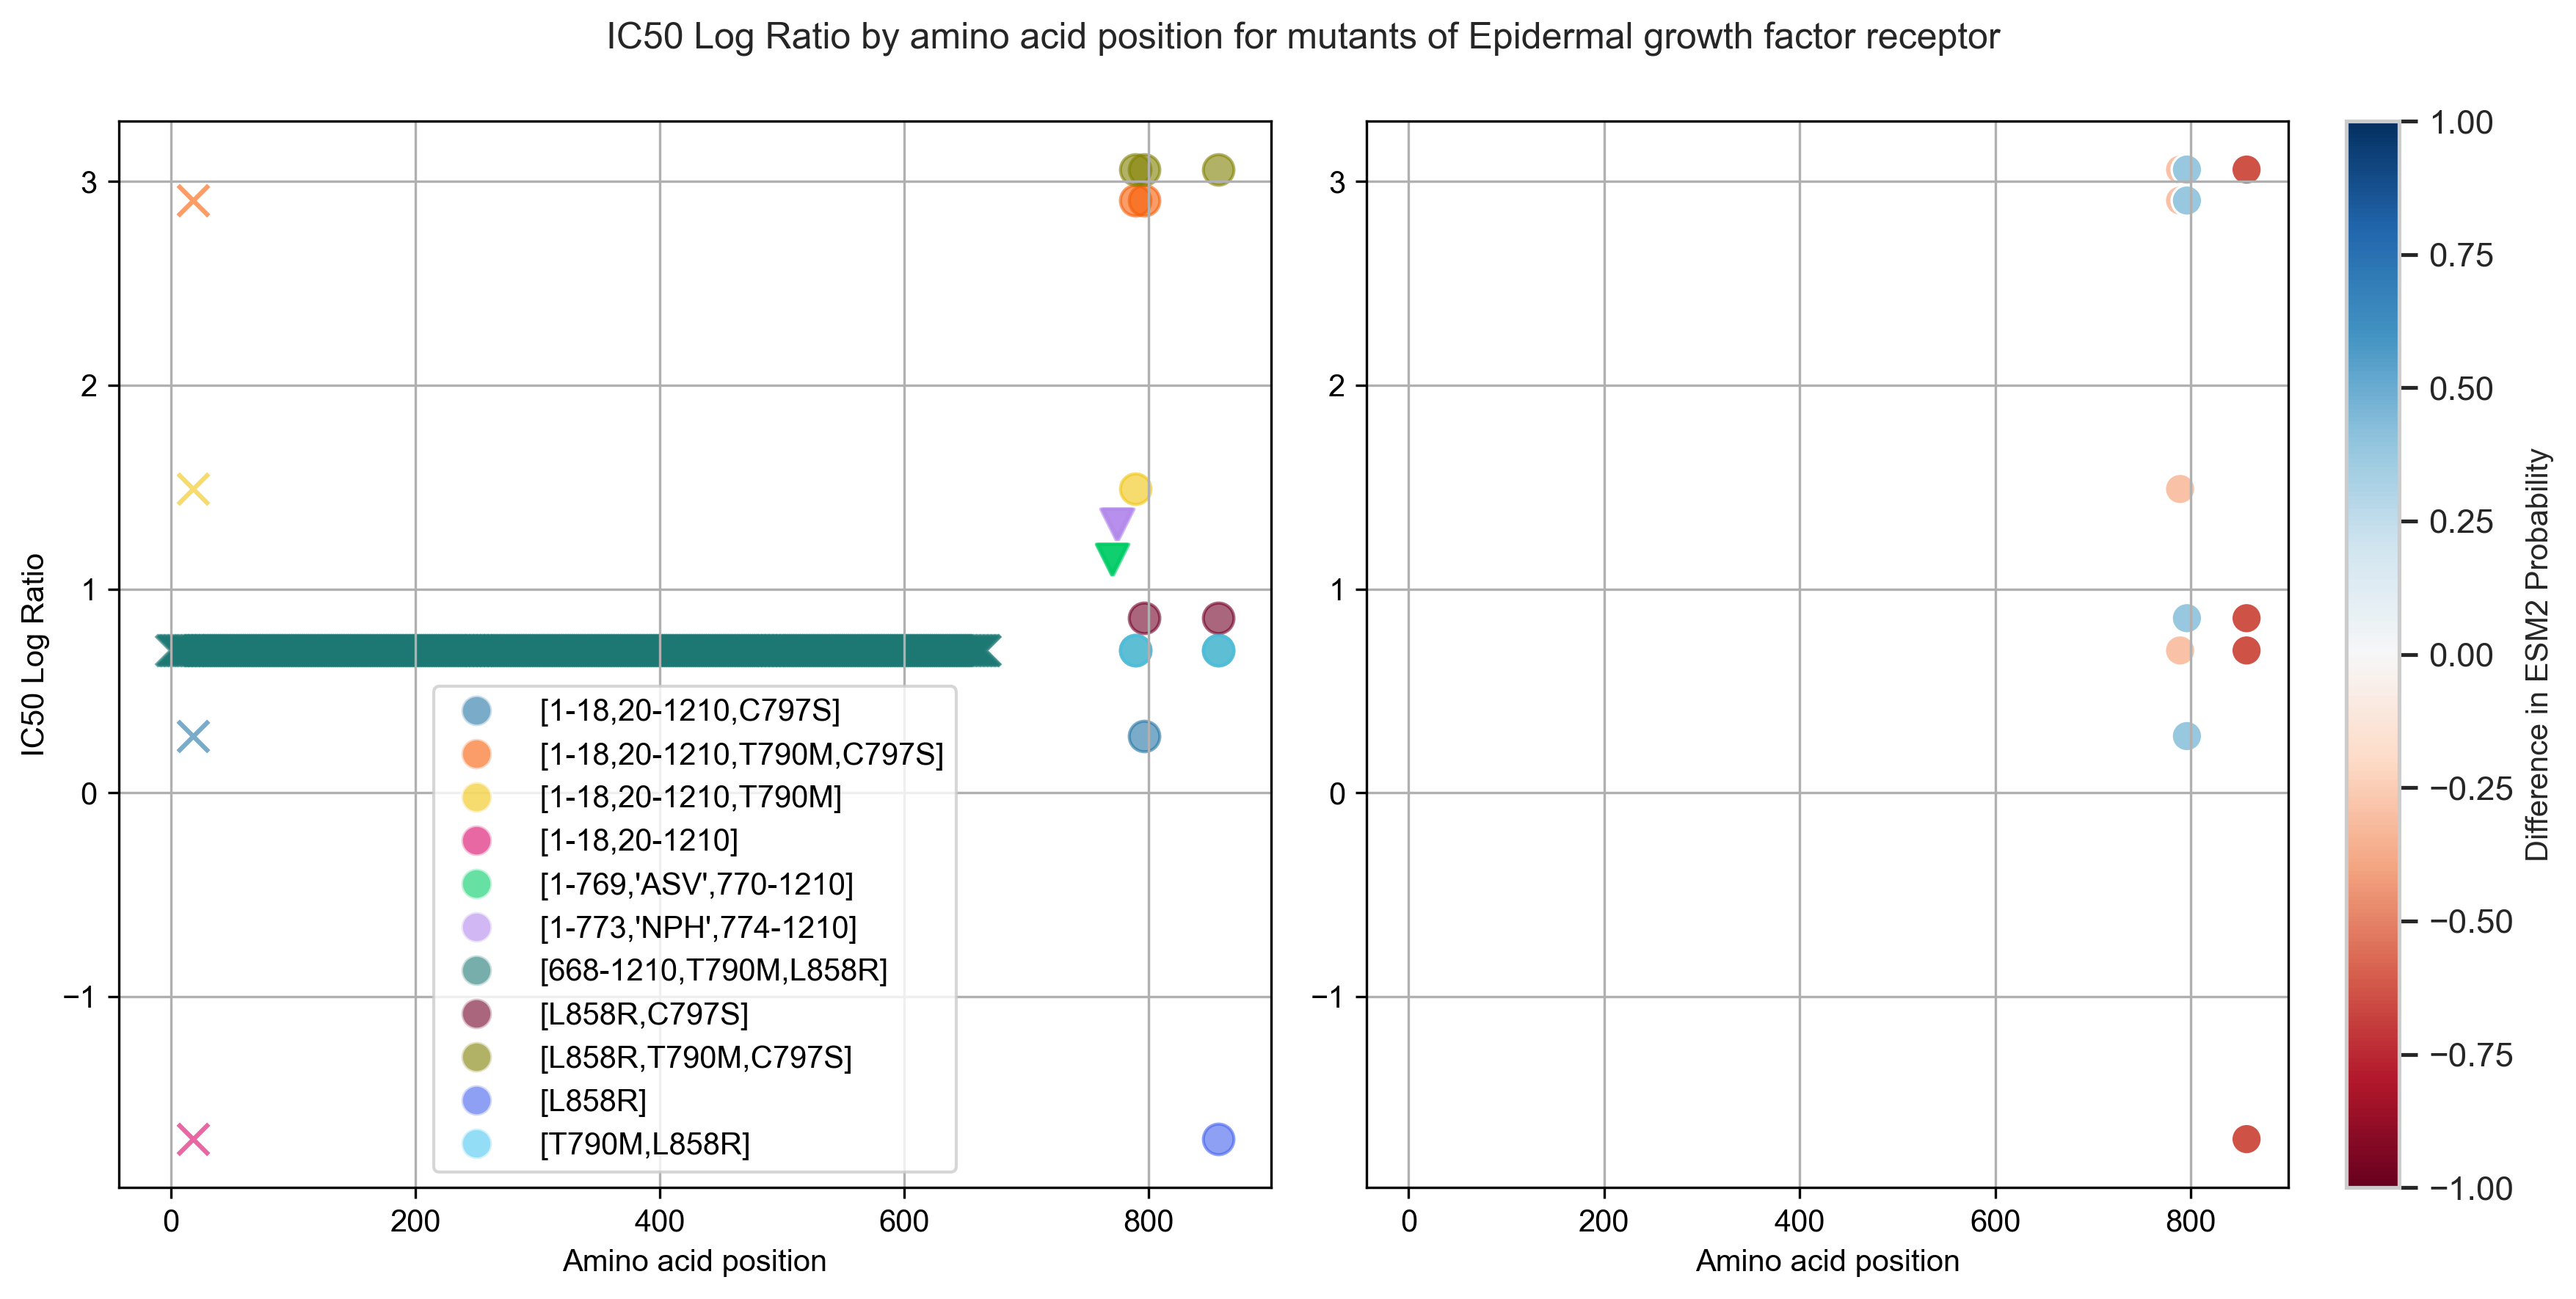

In [8]:
plot_ic50_both_graphs(row, merged_df, 'IC50 Log Ratio', title='IC50 Log Ratio')

There are three mutations on this plot:
- mutation at position 790 from Threonine to Methionine: the probability difference is around -0.2 meaning Threonine is more probable than Methionine according to ESM2. The difference being small, it is hard to draw any conclusions but the negative sign still indicates a similar idea as our previous plot in which we said that T790M was non-beneficial
- mutation at position 797 from Cysteine to Serine: the probability difference is around +0.3 indicating that Serine is more likely to be at that position compared to Cysteine according to ESM2
- mutation at position 858 from Leucine to Arginine: the probability difference is around -0.8 which strongly indicates that Leucine is more likely to be at that position compared to Arginine. This is partially in contradiction with our previous analysis that stated that this mutation was beneficial

Overall, as we'll see in our other analysis, binding affinity is not properly captured by ESM2 and these results should be taken with a grain of salt.

### Barplots

So far, we looked at a given interaction pair Ligand - WT protein and looked at the impact of mutants of that WT protein on binding affinity. Luckily, in the five selected pairs, there are only two WT proteins: EGFR_HUMAN and KAPCA_BOVIN. An interesting study consists of inverting the point of view and trying to understand the impact of the ligand on the binding affinity for a given pair WT protein - Mutant. To do this, we collected the data for the five interaction pairs.

In [9]:
# Load the data (we need all of it not like first part)
interaction_pairs = save_dfs_ligands(merged_df, mutants_df)
interaction_pairs.to_csv('../data/interaction_pairs.csv')
final_df = bar_plot_df('../data/interaction_pairs.csv', '../data/prot_viz')

Device set to use cpu


Pair information succesfully saved
---------------------------------------------------------------------------


Device set to use cpu


Pair information succesfully saved
---------------------------------------------------------------------------
For this ligand-protein pair there are multiple values of IC50 and we decided to drop this case.
This pair will not be saved due to multiple conflicting values in BindingDB
---------------------------------------------------------------------------


Device set to use cpu


Pair information succesfully saved
---------------------------------------------------------------------------


Device set to use cpu


Pair information succesfully saved
---------------------------------------------------------------------------


Device set to use cpu


Pair information succesfully saved
---------------------------------------------------------------------------
For this ligand-protein pair there are multiple values of IC50 and we decided to drop this case.
This pair will not be saved due to multiple conflicting values in BindingDB
---------------------------------------------------------------------------


To visualize this study, we produced two plots one for each WT protein. The bar plots shows once again the log ratio of IC50 values and each group of bars represents this value for a given WT/mutant pair. The different colors represent the ligand associated with a given value.

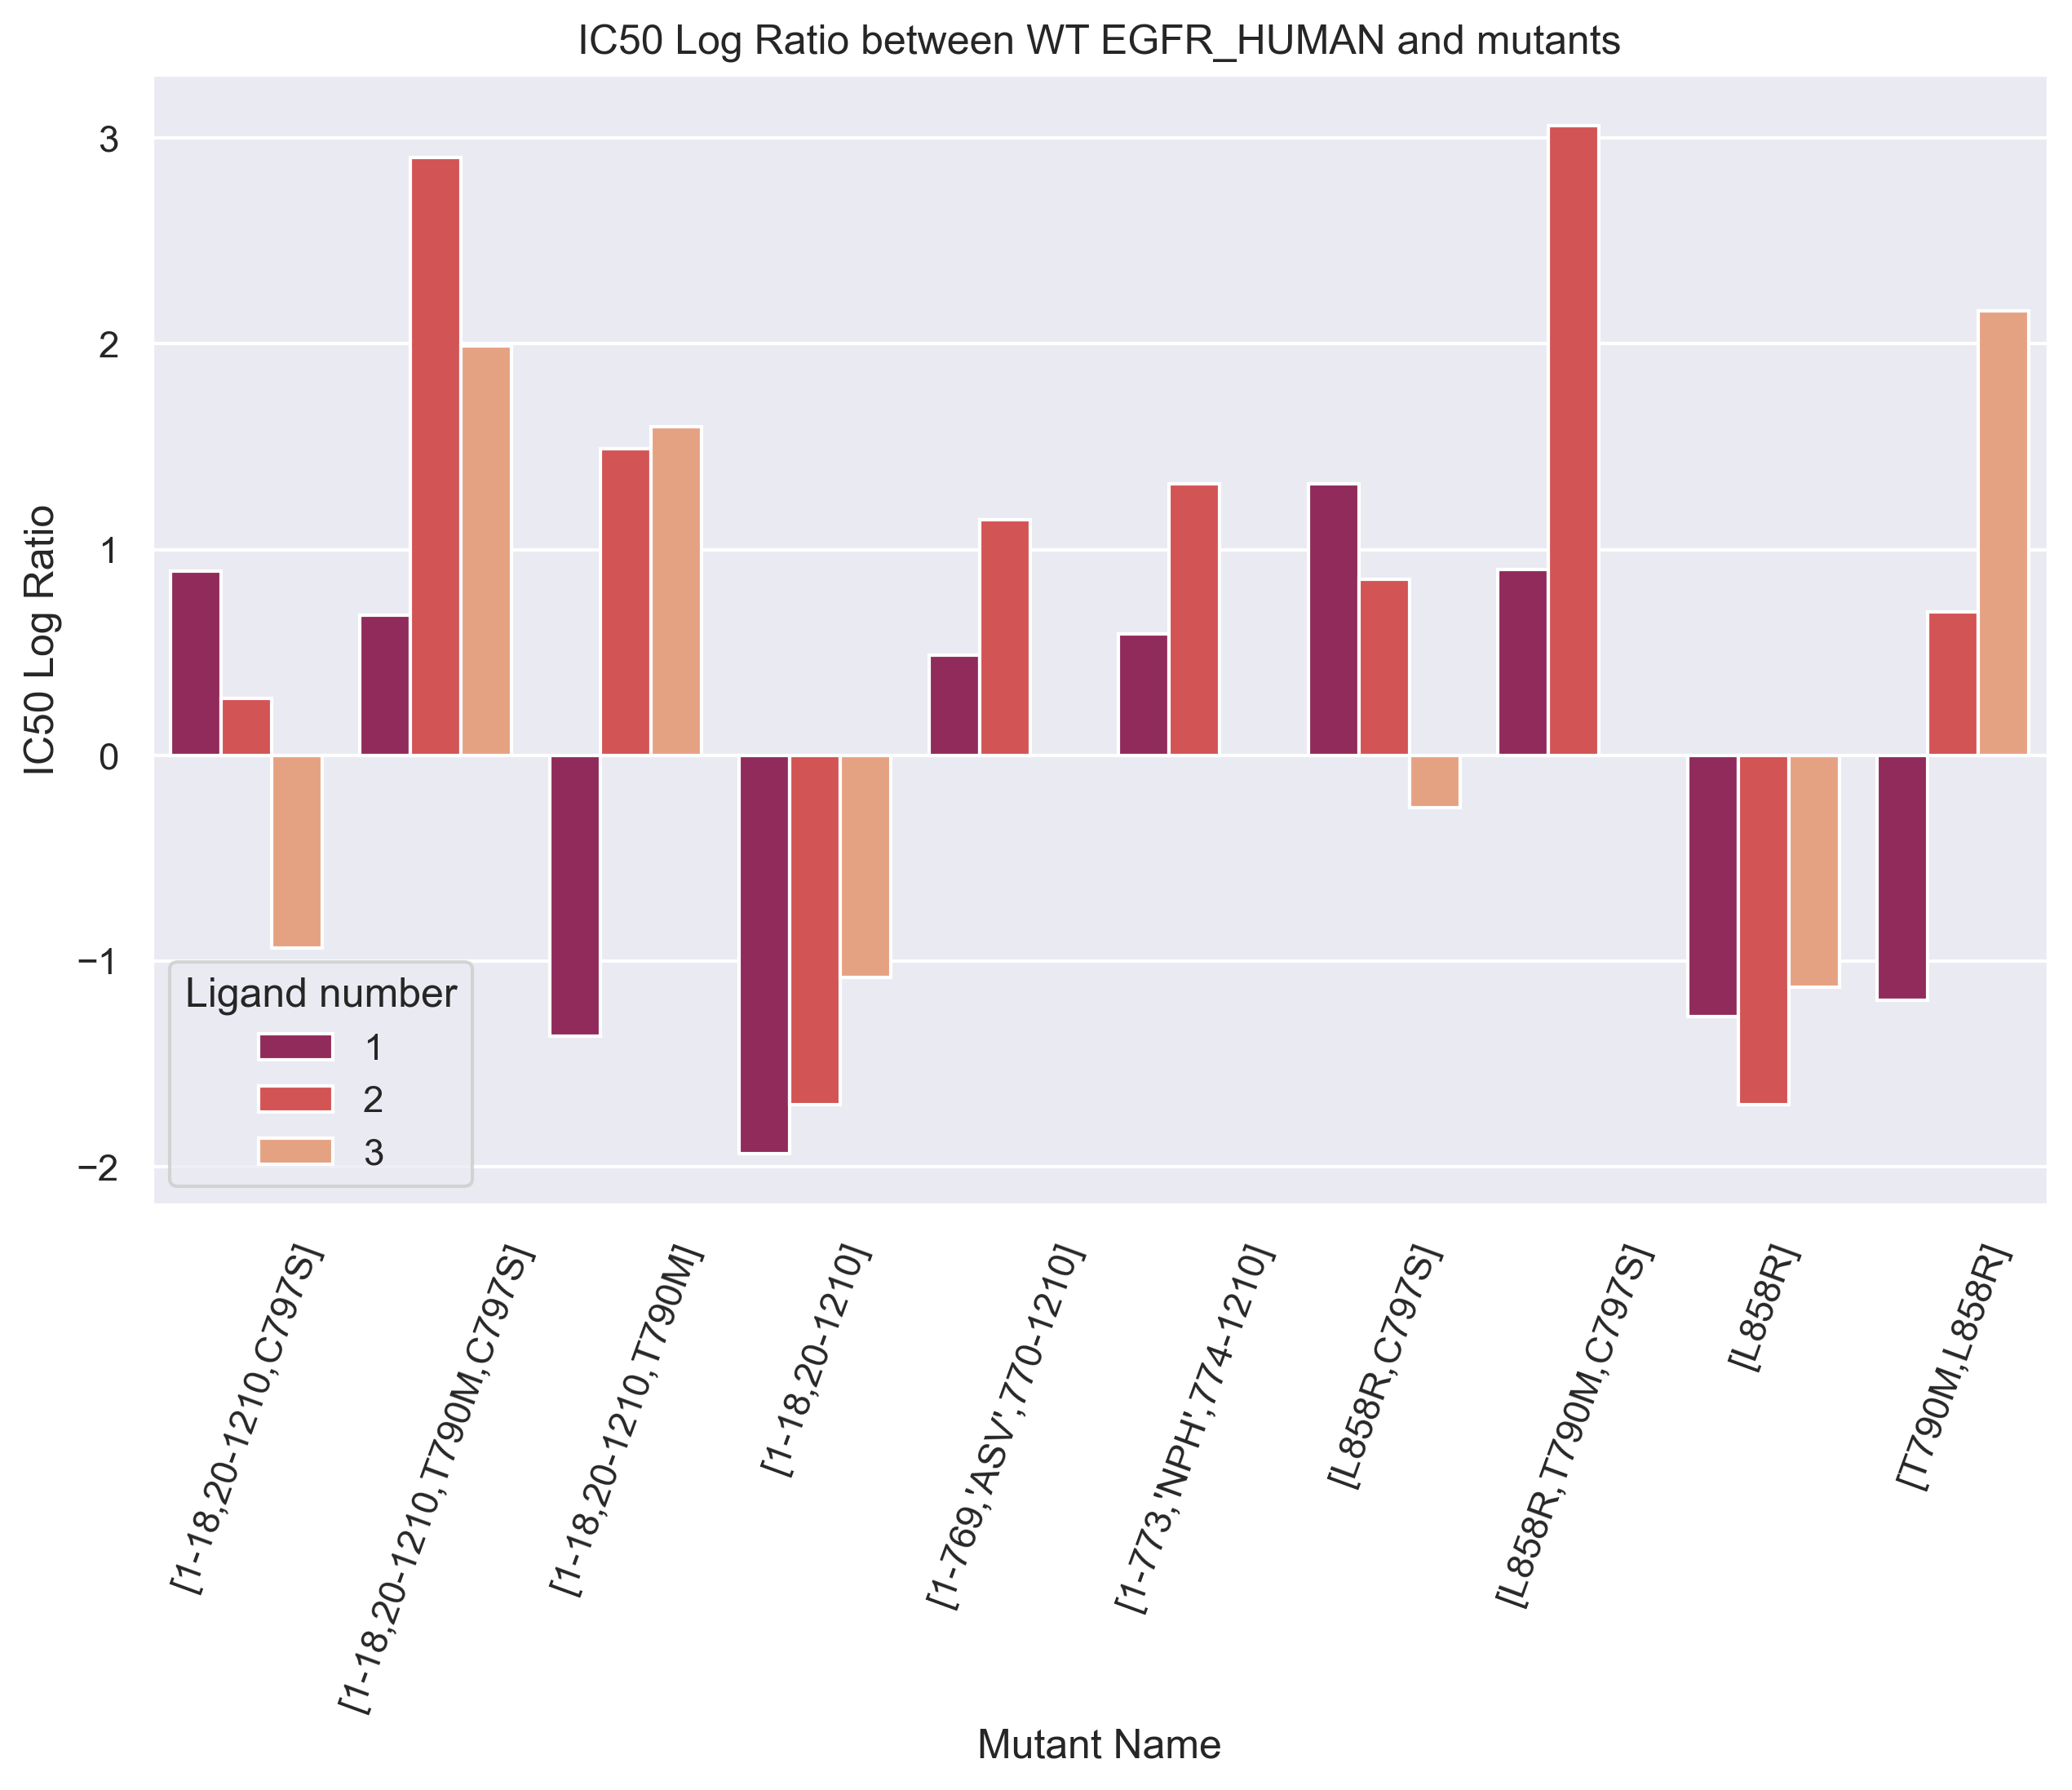

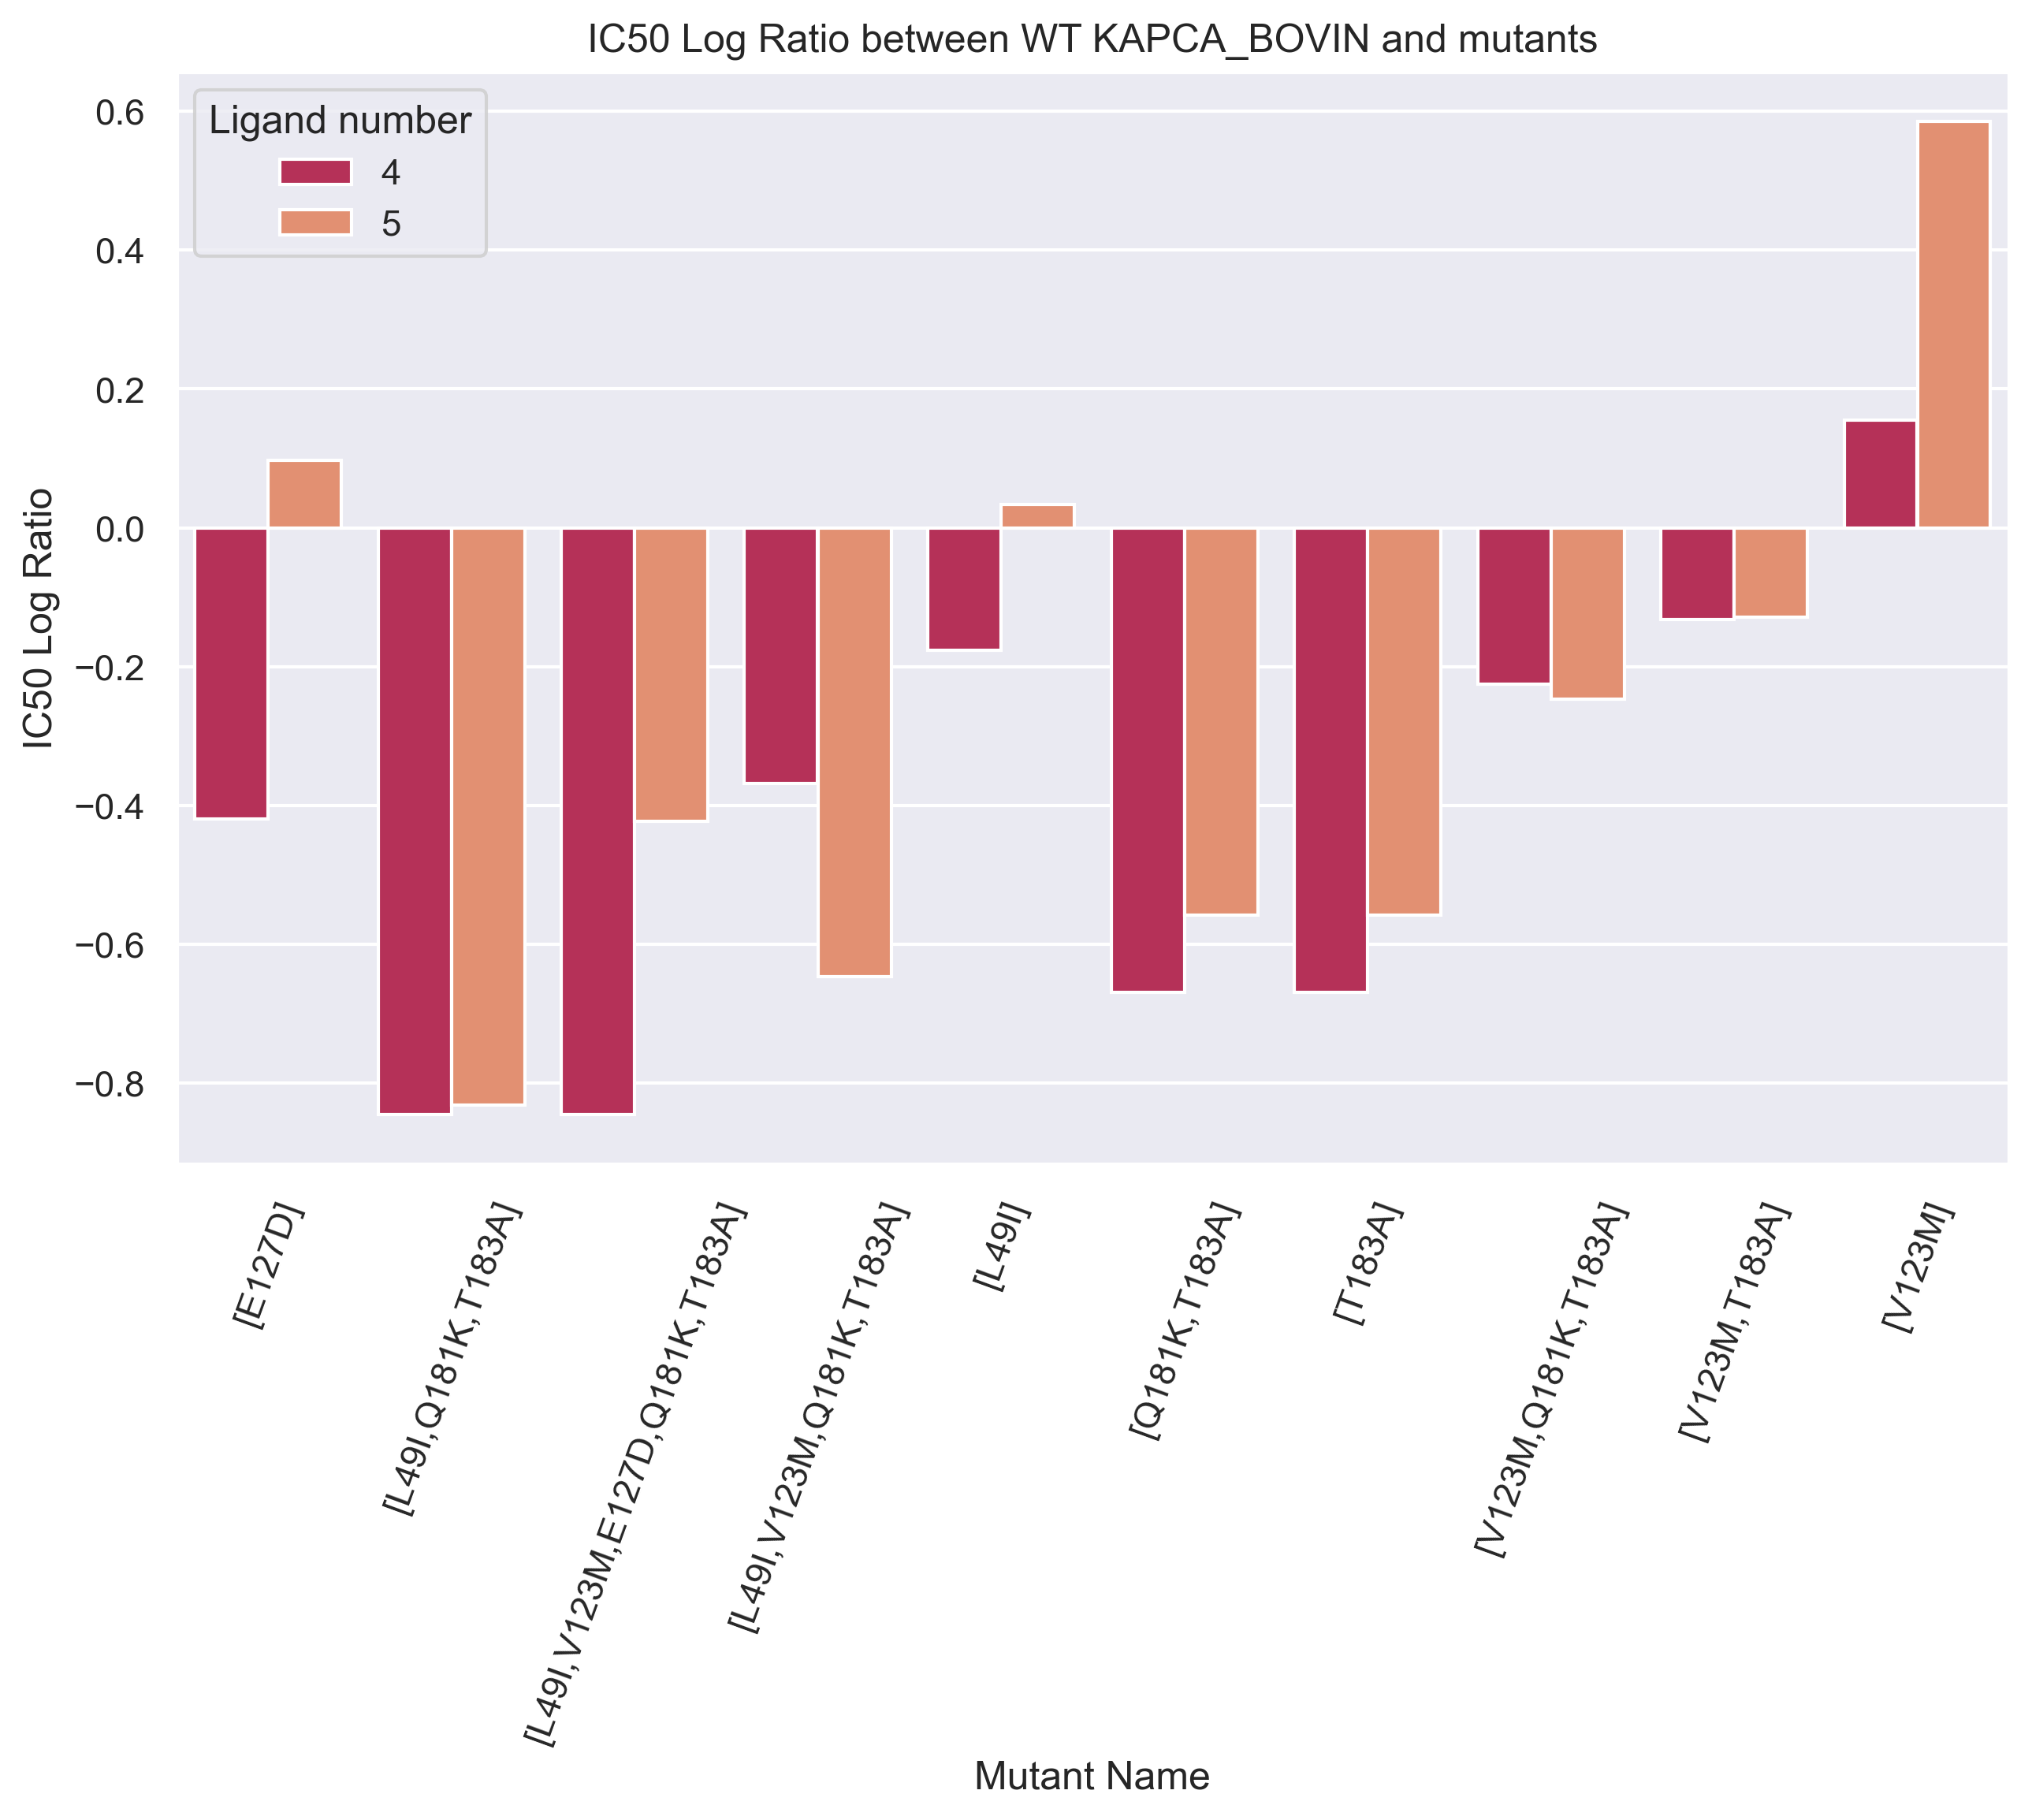

In [10]:
# Bar plot
for name, group in final_df.groupby('WT protein'):
        plt.close()
        plt.figure(figsize=(10, 6), dpi = 300) 
        sns.set_style("darkgrid")
        custom_palette = sns.color_palette("rocket", n_colors=len(group['Ligand number'].unique())+1)
        custom_palette = custom_palette[1:] 
        sns.barplot(x='Mutant Name', y='IC50 Log Ratio', hue='Ligand number', data=group, errorbar=None, palette=custom_palette)
        plt.title(f'IC50 Log Ratio between WT {name} and mutants')
        plt.xticks(rotation=70)
        plt.show()

The goal was to see if any clear trends arose from the plot. Logically, this is not the case, since binding affinity depends on many components and not only the properties of the ligand. 

Still, for the two last mutants shown on the first plot we observe two very different patterns even though there is only one different mutation. We can thus make multiple hypothesis such as:
- Position 790 is not important or not involved in the binding of the protein EGFR (and its mutants) with ligand 1
- the mutation T790M reduces the binding affinity with ligand 2 and ligand 3

Similarly, for the two last mutants shown on the second plot we see a big difference on the log ratio even though there is only one different mutation. We can thus make multiple hypothesis such as:
- Position 183 is important or involved in the binding of the protein KAPCA (and its mutants) with both ligand 4 and 5
- the mutation T183A reduces the binding affinity with ligand 4 and 5